In [1]:
# set cell display width
from IPython.display import display, HTML
display(HTML('<style>.container { width: 930px !important; }</style>'))

In [2]:
# import ML tools
import pandas as pd
import numpy as np
import statsmodels.api as sm
from sklearn.model_selection import train_test_split, cross_val_score, cross_validate
from sklearn.model_selection import GridSearchCV
from sklearn.base import BaseEstimator, RegressorMixin
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import  ElasticNet
from statsmodels.graphics.gofplots import qqplot

In [3]:
# import plotting tools
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.core.pylabtools import figsize
# set grid size and style
figsize(12, 4)
sns.set_style('whitegrid')

Use "mp.colors(<index>)" as color attribute for Seaborn plots.
This is your color palette...


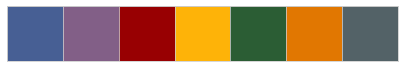

In [4]:
# import custom palette
import my_palette as mp

In [5]:
# read in actor dataset
df = pd.read_json('capstone1_ds.json')

> **GIVEN TARGET**

I will start with analyzing the unmodified dataset.

In [6]:
# observe dimensionality of dataset
df.shape

(11693, 28)

There are 27 independent variables.

In [7]:
# observe feature names
df.columns

Index(['actor_value', 'budget', 'age', 'gender', 'order', 'popularity',
       'release_date', 'runtime', 'usa', 'vote_average', 'vote_count',
       'action', 'adventure', 'animation', 'comedy', 'crime', 'drama',
       'family', 'fantasy', 'history', 'horror', 'music', 'mystery', 'romance',
       'science_fiction', 'thriller', 'war', 'western'],
      dtype='object')

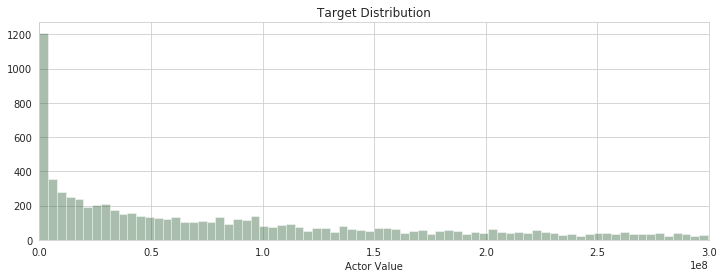

In [8]:
# plot target distribution up to $300,000,000

plt.xlim(0, 3e8)

sns.distplot(df['actor_value'], bins=5000, color=mp.colors(4), 
             axlabel='Actor Value', kde=False)

plt.title('Target Distribution');

In [9]:
def plot_correlations(data):
    """Return heatmap plot of correlations"""
    fig, ax = plt.subplots(figsize=(26,30))

    sns.set(font_scale=1.5)
    sns.heatmap(
        data.corr(), vmin=0, vmax=1.0, center=0, fmt='0.2f', square=True, 
        linewidths=0.5, annot=True, cbar_kws={"shrink": 0.60});

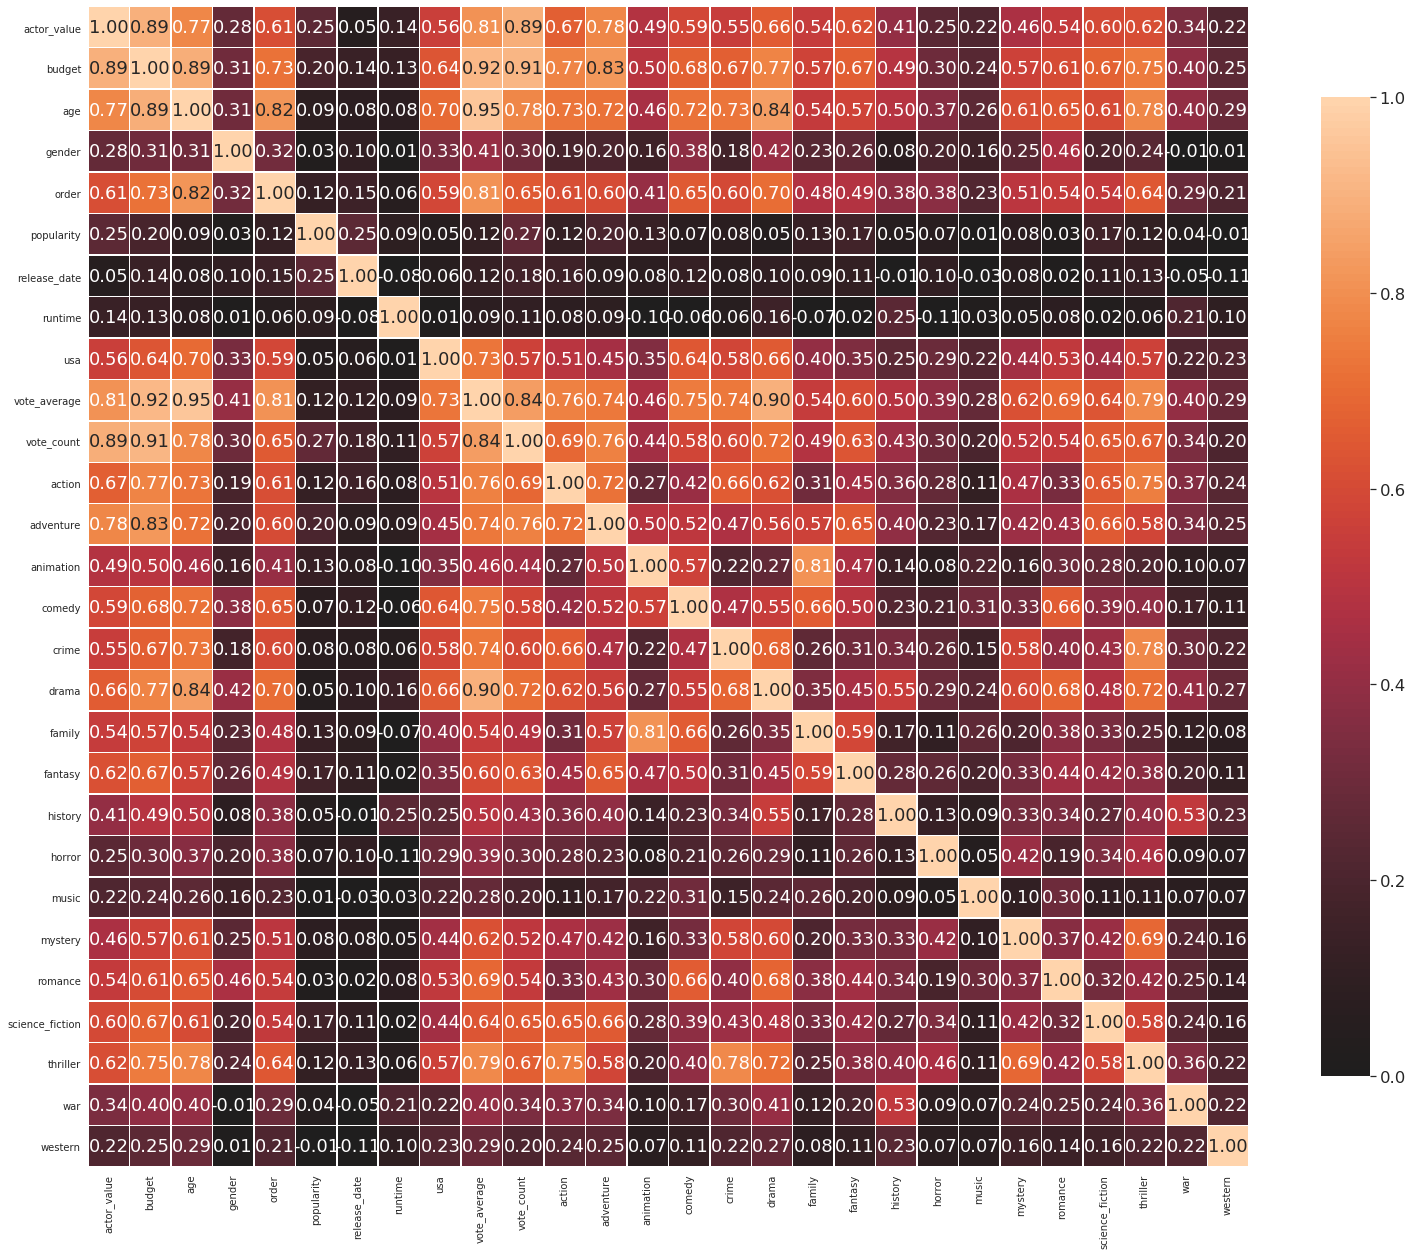

In [10]:
# plot correlations in dataset
plot_correlations(df)

The target variable has many correlations, even before manipulating the data for performance gains.

In [11]:
# separate data into features and target
X = df.drop('actor_value', axis=1)
X = sm.add_constant(X)
y = df['actor_value']

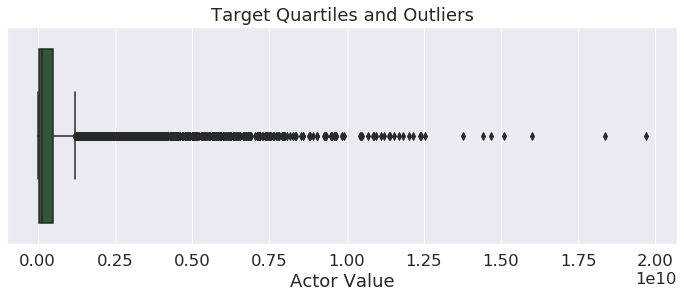

In [12]:
# plot target quartiles and outliers

sns.boxplot(y, color=mp.colors(4))

plt.xlabel('Actor Value')
plt.title('Target Quartiles and Outliers');

There are many outliers among the targets.

In [13]:
# get statistics for target
y.describe()

count    1.169300e+04
mean     5.647359e+08
std      1.243346e+09
min      1.238841e+00
25%      3.130126e+07
50%      1.396449e+08
75%      5.060413e+08
max      1.970652e+10
Name: actor_value, dtype: float64

The standard deviation is large compared to the mean, due to the many high-valued outliers.

First, I will split the data to create a holdout set for validation.

In [14]:
# split dataset
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=27)

In [15]:
def get_ols_model(features, target):
    """Return ordinary least squares regressor"""
    mod_ols = sm.OLS(target, features)
    results = mod_ols.fit()
    
    return results

In [16]:
# get OLS fitted regressor
ols_model = get_ols_model(X_train, y_train)

In [17]:
# get OLS results
print(ols_model.summary())

                            OLS Regression Results                            
Dep. Variable:            actor_value   R-squared:                       0.864
Model:                            OLS   Adj. R-squared:                  0.863
Method:                 Least Squares   F-statistic:                     2189.
Date:                Thu, 09 Jul 2020   Prob (F-statistic):               0.00
Time:                        13:49:39   Log-Likelihood:            -1.9966e+05
No. Observations:                9354   AIC:                         3.994e+05
Df Residuals:                    9326   BIC:                         3.996e+05
Df Model:                          27                                         
Covariance Type:            nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
const            1.114e+10   5.08e+08     

The OLS model is performing very well on the dataset.<br>
The coefficient of determination is high, right out of the gate.

I will implement a wrapper to use the results of the Statsmodels regressor with a Scikit Learn cross-validation model.

In [18]:
class SMWrapper(BaseEstimator, RegressorMixin):
    """Return a scikit learn wrapper for statsmodels regressors"""
    def __init__(self, model_class, fit_intercept=True):
        self.model_class = model_class
        self.fit_intercept = fit_intercept
    def fit(self, X, y):
        if self.fit_intercept:
            X = sm.add_constant(X)
        self.model_ = self.model_class(y, X)
        self.results_ = self.model_.fit()
    def predict(self, X):
        if self.fit_intercept:
            X = sm.add_constant(X)
        return self.results_.predict(X)

In [19]:
def get_cv_results(features, target):
    """Return cross-validation average score and score range results"""
    cv_results = cross_val_score(SMWrapper(sm.OLS), features, target, cv=10, n_jobs=-1)
    # round scores to 5 decimal places
    results = np.round(cv_results, 5)
    # get range of scores
    results_range = (np.min(results), np.max(results))
    # get average score and round to 5 decimal places
    ave_result = np.round(np.mean(cv_results), 5)
        
    return f'Average Score: {ave_result}, Score Range: {results_range}'

In [20]:
# get statistics for 10 fold cross-validation
get_cv_results(X_train, y_train)

'Average Score: 0.8618, Score Range: (0.83041, 0.89208)'

The range of cross-validation scores is wide, but this result from the initial model indicates it is not overfit.

I will use a few standard methods for optimizing the fit and generalizability of the model.

> **SIGNIFICANT FEATURES**

There are a few predictors that are not statistically significant above 98%.<br>
These variables are action, horror, music, and war movie genres.<br>
I will observe the ground truth with respect to each predictor to look for possible heteroscedasticity.

In [21]:
# select variables to observe
features_lst = ['action', 'horror', 'music', 'war']

In [22]:
def plot_features(features, target, model, features_lst):
    """Return plots of selected features vs. residuals"""
    for variable in features_lst:        
        sns.scatterplot(features[variable], model.resid, s=10, color=mp.colors(2))

        plt.xlabel(variable.capitalize())
        plt.ylabel('Residuals')
        
        plt.title("Feature vs Residuals")
        plt.show()

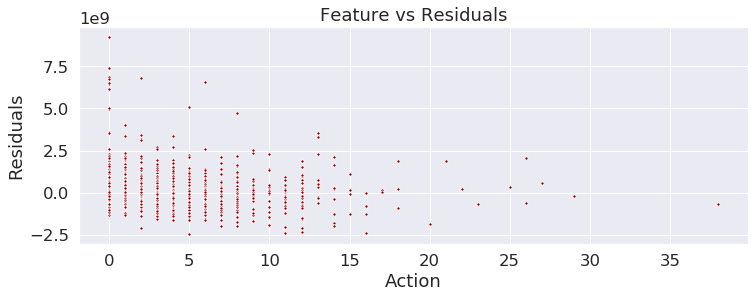

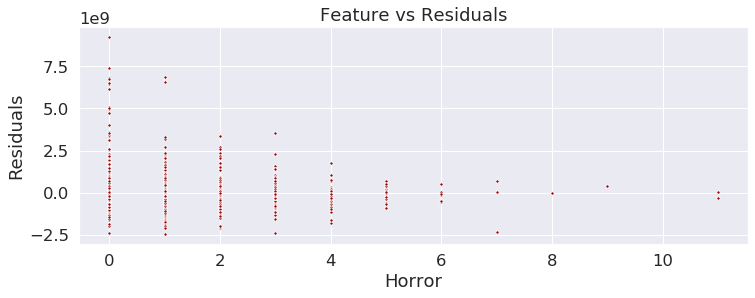

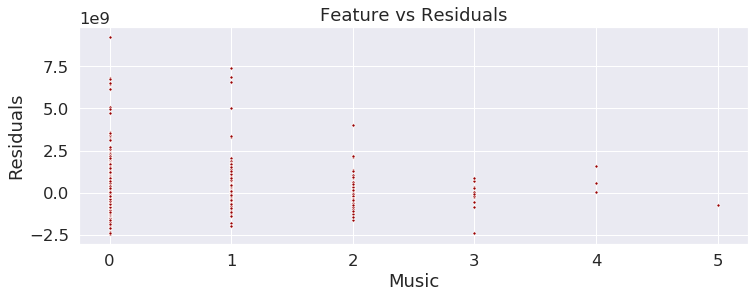

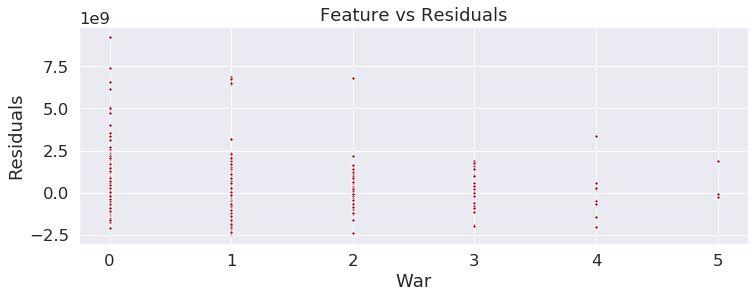

In [23]:
# plot selected features vs. residuals
plot_features(X_train, y_train, ols_model, features_lst)

The variabilities of all four predictors decrease as the counts increase.

I will remove the action, horror, music, and war movie genres to see is there is model improvement.

In [24]:
# add target to features list to create drop list
drop_features = features_lst + ['actor_value']

In [25]:
# separate data into significant features and target
X_sig = df.drop(drop_features, axis=1)
X_sig = sm.add_constant(X_sig)
y_sig = df['actor_value']

In [26]:
# split dataset
X_train_sig, X_test_sig, y_train_sig, y_test_sig = train_test_split(
    X_sig, y_sig, test_size=0.2, random_state=27)

In [27]:
# get OLS fitted regressor for significant features
ols_model_sig = get_ols_model(X_train_sig, y_train_sig)

In [28]:
# get OLS results for target using a subset of features
print(ols_model_sig.summary())

                            OLS Regression Results                            
Dep. Variable:            actor_value   R-squared:                       0.864
Model:                            OLS   Adj. R-squared:                  0.863
Method:                 Least Squares   F-statistic:                     2569.
Date:                Thu, 09 Jul 2020   Prob (F-statistic):               0.00
Time:                        13:49:41   Log-Likelihood:            -1.9966e+05
No. Observations:                9354   AIC:                         3.994e+05
Df Residuals:                    9330   BIC:                         3.995e+05
Df Model:                          23                                         
Covariance Type:            nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
const            1.109e+10   5.01e+08     

The R-squared scores are the same.<br>
The F statistic has improved slightly.<br>
The A.I.C. scores are identical, implying no difference in the models.<br>
All of the remaining predictors are statistically significant to more than 99%.

In [29]:
# get statistics for 10 fold cross-validation
get_cv_results(X_train_sig, y_train_sig)

'Average Score: 0.86208, Score Range: (0.83079, 0.89243)'

The evaluation metrics are slightly better with this model.

I will compare the cross-validation results of the two models.

In [30]:
def get_cv_df(features, target):
    """Return DataFrame of scores and print CV average score"""
    cv_score = cross_validate(SMWrapper(sm.OLS), features, target, cv=10, n_jobs=-1, 
                               return_train_score=True)
    
    ave_result = np.round(np.mean(cv_score['test_score']), 5)
        
    print('Mean Score: {}'.format(ave_result))
    
    return pd.DataFrame(cv_score).loc[:, ['test_score', 'train_score']].sort_values(
        'test_score', ignore_index=True)

In [31]:
# run cross-validation with original features and retain results in DataFrame
cv_df = get_cv_df(X_train, y_train)
cv_df.columns = cv_df.columns + '_original'

Mean Score: 0.8618


In [32]:
# run cross-validation with only significant features and retain results in DataFrame
cv_sig_df = get_cv_df(X_train_sig, y_train_sig)
cv_sig_df.columns = cv_sig_df.columns + '_sig'

Mean Score: 0.86208


In [33]:
def compare_results(results_1, results_2):
    """Plot CV results from 2 models for comparision"""
    df = pd.concat([results_1, results_2], axis=1)
    
    sns.lineplot(data=df, marker='o')

    plt.xlabel('Fold')
    plt.ylabel('R2 Score')
    
    plt.legend(loc=2, ncol=2, fontsize='xx-small', framealpha=0.3)
    plt.title('Cross-validation Results');

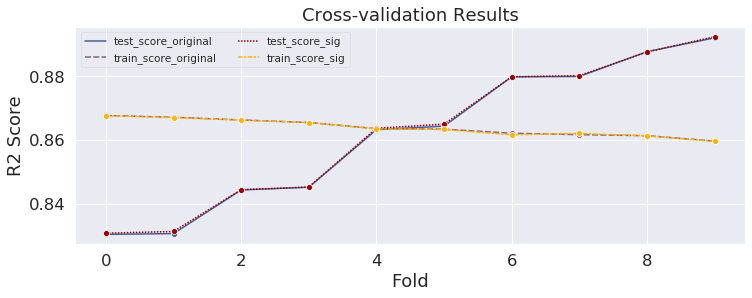

In [34]:
# compare CV results
compare_results(cv_df, cv_sig_df)

The results almost completely overlap.

Now, I will observe the differences between the average training and test scores for each model.

In [35]:
def get_score_delta(results):
    """Return difference between average training score and average test score"""
    delta = np.mean(results.iloc[:, 1:2].values) - np.mean(results.iloc[:, :1].values)
    delta = np.round(delta, 13)
    
    return f'Difference of average training and test scores: {delta}'

In [36]:
# get training and test delta for original model
get_score_delta(cv_df)

'Difference of average training and test scores: 0.0020754269931'

In [37]:
# get training and test delta for model with only significant predictors
get_score_delta(cv_sig_df)

'Difference of average training and test scores: 0.0017286002918'

There is a small gain in robustness when removing the predictors that are not statistically significant.

> **SCALED FEATURES**

Standardizing the predictors is another way of guarding against overfitting.<br>
I will do this, now.

In [38]:
# instantiate standard scaler and fit to training features
scaler = StandardScaler().fit(X_train)

In [39]:
# transform all features
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [40]:
# get statistics for 10 fold cross-validation on scaled data
get_cv_results(X_train_scaled, y_train)

'Average Score: 0.8618, Score Range: (0.83041, 0.89208)'

In [41]:
# run cross-validation with scaled features and retain results in DataFrame
cv_scaled_df = get_cv_df(X_train_scaled, y_train)
cv_scaled_df.columns = cv_scaled_df.columns + '_scaled'

Mean Score: 0.8618


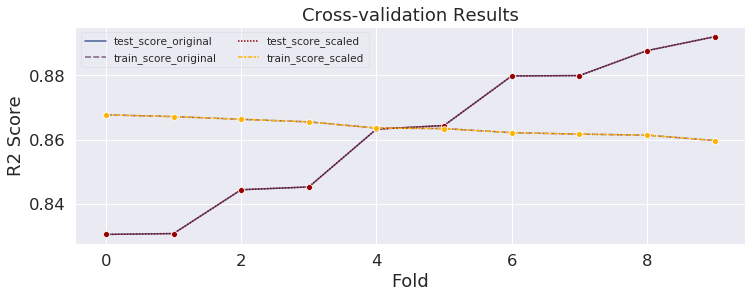

In [42]:
# compare CV results
compare_results(cv_df, cv_scaled_df)

Now, the data has completely overlapped.

I will recall the overfitting metric from the original model for comparison.

In [43]:
# get training and test delta for original model
get_score_delta(cv_df)

'Difference of average training and test scores: 0.0020754269931'

In [44]:
# get training and test delta for scaled model
get_score_delta(cv_scaled_df)

'Difference of average training and test scores: 0.0020754269955'

There is no significant advantage to scaling the features for this model.

> **NO OUTLIERS TARGET**

I will look for improvements by removing outliers using the z-score criterion.

In [45]:
# get number of outlier observations according to z-score criterion
z = (df["actor_value"] - np.mean(df["actor_value"])) / np.std(df["actor_value"])
(np.absolute(z) > 3).sum()

272

In [46]:
# find percentage of outliers in datset having Z-Score > 3
(np.absolute(z) > 3).sum() / df.shape[0] * 100

2.3261780552467286

I will remove a small portion of the observations and look for a boost in model robustness.

In [47]:
# drop target outliers
no_df = df.drop(
    index=df.loc[np.absolute(
        np.divide(
            np.subtract(
                df["actor_value"], np.mean(df["actor_value"])
            ), np.std(df["actor_value"]))) > 3].index)

In [48]:
# separate data into features and target
X_no = no_df.drop('actor_value', axis=1)
X_no = sm.add_constant(X_no)
y_no = no_df['actor_value']

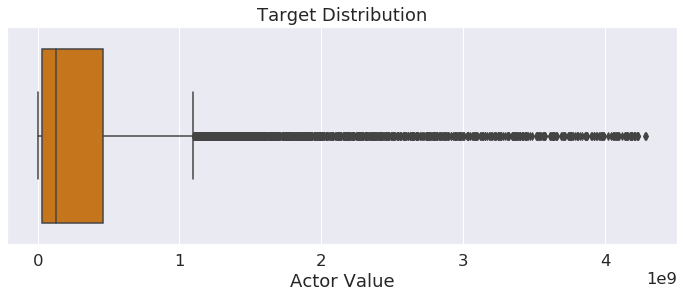

In [49]:
# plot target quartiles and outliers

sns.boxplot(y_no, color=mp.colors(5))

plt.xlabel('Actor Value')
plt.title('Target Distribution');

In [50]:
# get statistics for target
y_no.describe()

count    1.142100e+04
mean     4.153170e+08
std      6.907746e+08
min      1.238841e+00
25%      2.956956e+07
50%      1.324197e+08
75%      4.575525e+08
max      4.291780e+09
Name: actor_value, dtype: float64

The scale of the target has dropped by a factor of 10.

In [51]:
# split dataset
X_train_no, X_test_no, y_train_no, y_test_no = train_test_split(
    X_no, y_no, test_size=0.2, random_state=27)

In [52]:
# get statistics for 10 fold cross-validation with no outliers target
get_cv_results(X_train_no, y_train_no)

'Average Score: 0.81317, Score Range: (0.73486, 0.8486)'

In [53]:
# run cross-validation with no outliers target and retain results in DataFrame
cv_no_df = get_cv_df(X_train_no, y_train_no)
cv_no_df.columns = cv_no_df.columns + '_no'

Mean Score: 0.81317


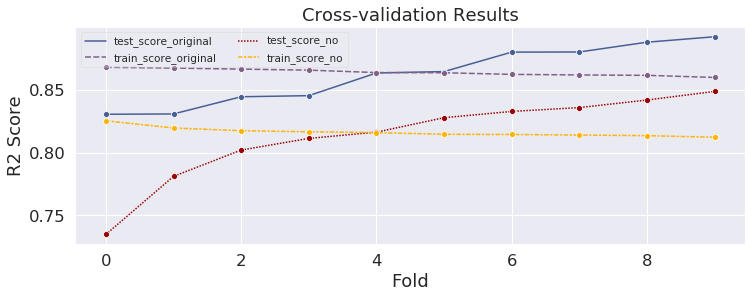

In [54]:
# compare CV results
compare_results(cv_df, cv_no_df)

Removing the outliers has reduced the performance on both the training and test data.

Again, I will recall the overfitting metric for the original model.

In [55]:
# get training and test delta for original model
get_score_delta(cv_df)

'Difference of average training and test scores: 0.0020754269931'

In [56]:
# get training and test delta for model with no outliers target
get_score_delta(cv_no_df)

'Difference of average training and test scores: 0.003096939456'

Removing the outliers would make the model less robust to overfitting.

> **REGULARIZATION: ELASTIC NET**

Under the correct conditions, OLS is the best linear estimator for producing unbiased estimates (BLUE).<br>
These 6 conditions are often difficult for data to meet.<br>
I will use a regularization method having two hyperparameters that can be tuned to look for a better regression model.

In [57]:
# set range of first hyperparameter
l1_ratio_lst = [0.05, 0.15, 0.5, 0.7, 0.9, 0.95, 0.99, 1]

In [58]:
# set range of second hyperparameter
alphas_lst = [0.0001, 0.001, 0.01, 0.1, 0.3, 0.5, 0.7, 1]

In [59]:
# set parameter grid to search for best elastic net model
param_grid = {'l1_ratio': l1_ratio_lst, 'alpha': alphas_lst}

In [60]:
def get_best_model(train_features, train_target, grid):
    """Return best model for randomized hyperparameter grid search"""
    # instantiate model
    enr_model = ElasticNet(random_state=27, max_iter=1e4, tol=0.01)
    # instantiate grid search model
    gs_cv = GridSearchCV(estimator=enr_model, param_grid=grid, scoring='r2', n_jobs=-1, 
                         cv=10, return_train_score=True, verbose=2)
    # fit search model
    gs_cv.fit(train_features, train_target)
    # get best model
    best_model = gs_cv.best_estimator_
    # get cross-validation results
    results_df = pd.DataFrame(
        gs_cv.cv_results_).set_index(
        'rank_test_score', drop=True).sort_index()
    
    return best_model, results_df

In [61]:
# get best elastic net estimator and grid search results
best_model, results = get_best_model(X_train, y_train, param_grid)

Fitting 10 folds for each of 64 candidates, totalling 640 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 24 concurrent workers.
[Parallel(n_jobs=-1)]: Done 114 tasks      | elapsed:  2.3min
[Parallel(n_jobs=-1)]: Done 317 tasks      | elapsed:  4.9min
[Parallel(n_jobs=-1)]: Done 640 out of 640 | elapsed:  6.9min finished


In [62]:
# examine parameters of best elastic net estimator
best_model

ElasticNet(alpha=0.1, copy_X=True, fit_intercept=True, l1_ratio=0.5,
           max_iter=10000.0, normalize=False, positive=False, precompute=False,
           random_state=27, selection='cyclic', tol=0.01, warm_start=False)

In [63]:
def get_gs_results(results):
    """Return DataFrame with grid search results sorted by best models"""
    # remove annoying prefix
    new_cols = [i[i.startswith('param_') and len('param_'):] 
                for i 
                in results.columns.to_list()]
    my_results = results.rename(dict(zip(results.columns, new_cols)), axis=1)
    # rename index
    my_results.index.names = ['rank']
    # set columns to return
    slices = [17, 29, 5, 4]
    
    return my_results.head(15).iloc[:, slices]

In [64]:
# observe best grid search models
get_gs_results(results)

,mean_test_score,mean_train_score,l1_ratio,alpha
rank,,,,
1,0.861962,0.863738,0.5,0.1
2,0.861962,0.863738,0.9,0.5
3,0.861962,0.863738,0.95,1
4,0.861953,0.863648,0.9,0.7
5,0.861950,0.863797,0.95,0.7
6,0.861940,0.863814,0.9,0.3
7,0.861940,0.863814,0.7,0.1
8,0.861933,0.863576,0.15,0.1
9,0.861928,0.863830,0.95,0.5


The top 3 models performed equally as well.<br>
There doesn't appear to be a pattern for best the hyperparameters.

In [65]:
def get_fold_means(results):
    """Return DataFrame with grid search results aggregated over each fold"""
    # set columns to return
    slices = list(range(7, 17)) + list(range(19, 29))
    my_results = results.iloc[:, slices].mean(axis=0)
    # assemble DataFrame
    test_series = pd.Series(my_results[:10].values, index=range(10))
    train_series = pd.Series(my_results[10:].values, index=range(10))
    results_df = pd.DataFrame(
        dict(test_score_en = test_series, train_score_en = train_series), index=range(10))
    
    return results_df.sort_values('test_score_en', ignore_index=True)

In [66]:
# get average results of training and test scores for each fold
en_df = get_fold_means(results)

I will recall the average differences of cross-validation scores for the original OLS model.

In [67]:
# get training and test delta for 10 ols fits
get_score_delta(cv_df)

'Difference of average training and test scores: 0.0020754269931'

In [68]:
# get training and test delta for all 640 elastic net fits
get_score_delta(en_df)

'Difference of average training and test scores: 0.0017793674143'

The average differences between training and test scores for each fold is better with the elastic net regularization method.<br>
It should be noted that the OLS method had very few folds and it's average is less precise.

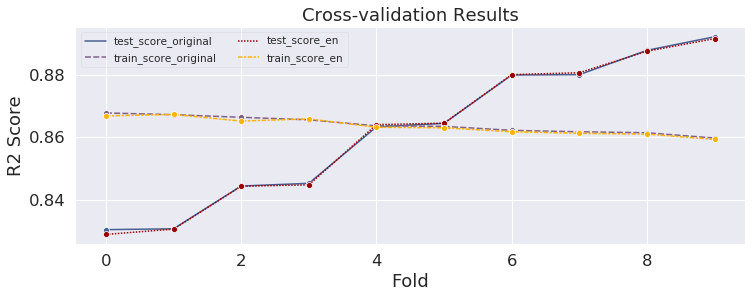

In [69]:
# compare CV results
compare_results(cv_df, en_df)

The two methods produce similar results over each fold.

Fortunately, we are not looking for the average fold, but the model with the best hyperparameters.<br>
The main advantage is that we now have optimal parameters to use.<br>
Hense, we are not limited by only being able to use the average result, but we can keep the best estimator, instead.

I will now compare the two best models.

In [70]:
def get_best_stats(results):
    """Return average score and difference of average training and average test scores"""
    best_test = get_gs_results(results)['mean_test_score'][1]
    best_train = get_gs_results(results)['mean_train_score'][1]    
    delta = np.round((best_train - best_test), 13)
    best_test = np.round(best_test, 13)
    
    return f'Mean Score : {best_test}, Delta of mean training and test scores: {delta}'

I will recall the statistics for the model with only significant predictors.

In [71]:
# get statistics for 10 fold cross-validation of model with only significant predictors
get_cv_results(X_train_sig, y_train_sig)

'Average Score: 0.86208, Score Range: (0.83079, 0.89243)'

In [72]:
# get training and test delta for model with only significant predictors
get_score_delta(cv_sig_df)

'Difference of average training and test scores: 0.0017286002918'

In [73]:
# get statistics for best elastic net estimator
get_best_stats(results)

'Mean Score : 0.861962412534, Delta of mean training and test scores: 0.0017755840825'

All of the models, except for the one with the removed outliers, performed almost identically.

Nonetheless, the best model is the one  with only significant predictors.<br>
I will use that one for the final evaluation on the holdout data.

> **FINAL MODEL**

First, I will observe some plots using the results of the best model on the training data.

In [74]:
def plot_predictions(features, target, model):
    """Return plot of observed target vs. predictions"""
    X_train, X_test, y_train, y_test = train_test_split(
        features, target, test_size=0.2, random_state=27)

    sns.scatterplot(y_test, model.predict(X_test), color=mp.colors(1))
    sns.regplot(y_test, model.predict(X_test), color=mp.colors(6), scatter=False)
    
    plt.xlabel('Observed')
    plt.ylabel('Predicted')
    
    plt.title("Ground Truth vs Predicted");

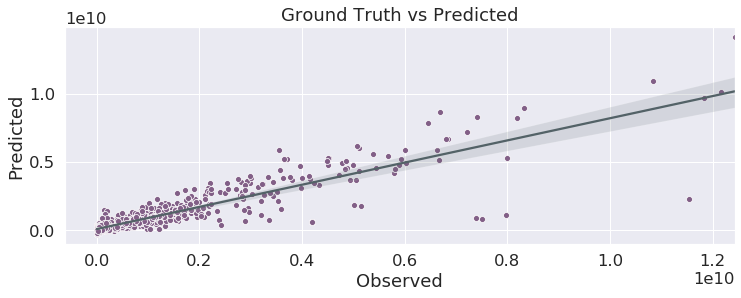

In [75]:
# plot observed target vs. predictions for best OLS model
plot_predictions(X_train_sig, y_train_sig, ols_model_sig)

The predicted values are fairly accurate.

In [76]:
def plot_residuals(features, target, model):
    """Return plot of predictions vs.residuals"""
    X_train, X_test, y_train, y_test = train_test_split(
        features, target, test_size=0.2, random_state=27)

    sns.residplot(
        model.predict(X_test), y_test, lowess=True, scatter_kws={'s':10}, 
        color=mp.colors(2), line_kws={'linewidth':3})
    
    plt.xlabel('Predicted Actor Value')
    plt.ylabel('Residuals')
    
    plt.title("Predicted vs Residuals");

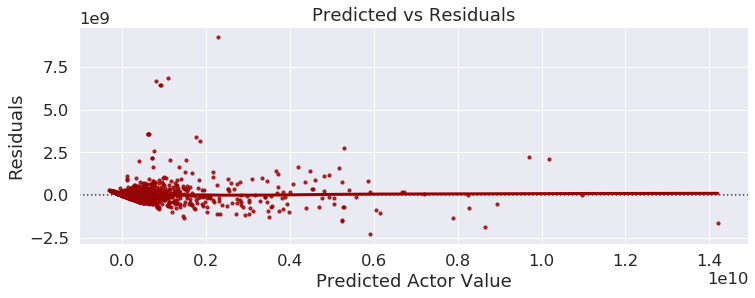

In [77]:
# plot predictions vs. residuals for best OLS model
plot_residuals(X_train_sig, y_train_sig, ols_model_sig)

The straight regression line indicates linearity between predictors and the target..

In [78]:
def plot_residual_distribution(features, target, model):
    """Return plot of distribution of residuals"""
    X_train, X_test, y_train, y_test = train_test_split(
        features, target, test_size=0.2, random_state=27)
    
    sns.distplot(
        (y_test - model.predict(X_test)), bins=300, rug=True, axlabel='Residuals', 
        color=mp.colors(4))

    plt.ylabel('Frequency')

    plt.title('Distribution of Residuals');

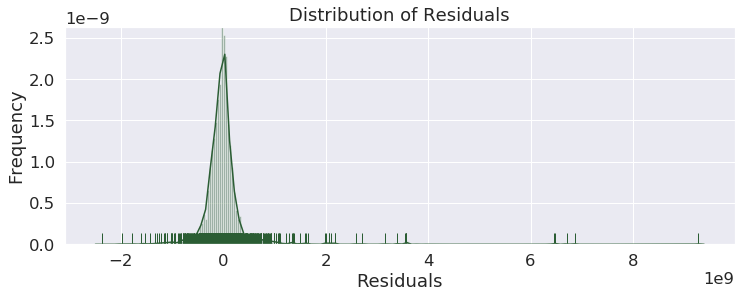

In [79]:
# plot residuals distribution for best OLS model
plot_residual_distribution(X_train_sig, y_train_sig, ols_model_sig)

Aside from a few outlier residuals, their distribution looks normal.

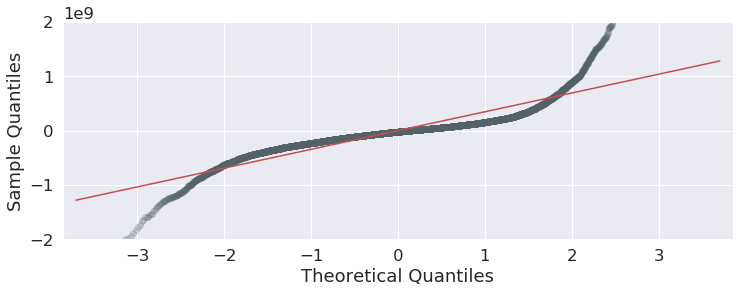

In [80]:
# get quantile-quantile plot for best OLS model
qqplot(ols_model_sig.resid, line='r', c=mp.colors(6), alpha=0.2)

plt.ylim(-2e9, 2e9)

plt.show()

The residuals significantly deviate from a normal distribution at around $800,000,000.

In [81]:
# get percentage of residuals outside of normal distribution
np.sum(ols_model_sig.resid > 8e8) / len(ols_model_sig.resid) * 100

2.6192003420996364

Most of the predictions are well distributed.

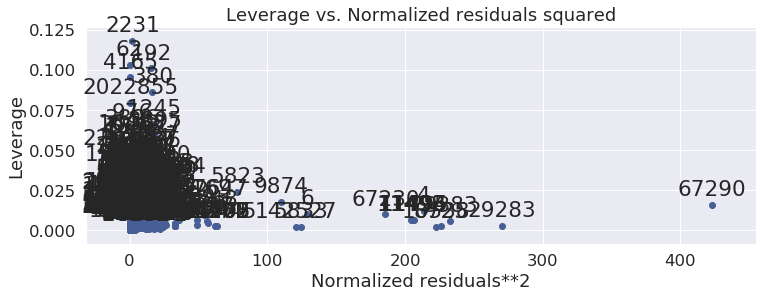

In [82]:
# get leverage plot for best OLS model
sm.graphics.plot_leverage_resid2(ols_model_sig)

plt.show()

The data points with high leverage are clustered near the others.<br>
This indicates that the model is not overly influenced by any one data point.<br>
The data points with the largest residuals all have low leverage<br>
This means that even though their errors are large, they are not greatly influencing the model.

Since I have the raw data, I'd like to see who is the most difficult actor to predict.<br>
I will look up the information on actor 67,290, the one with the largest residual.

In [83]:
# read in actor data before aggregation
ref_df = pd.read_json('capstone1_ref.json')

In [84]:
# get actor with largest residual
ref_df.loc[ref_df['person_id'] == 67290][['name', 'title', 'revenue', 'budget', 'profit',
                                          'age', 'order', 'release_date', 'vote_average']]

,name,title,revenue,budget,profit,age,order,release_date,vote_average
32964,Verna Felton,The Jungle Book,1.576597e+09,3.063680e+07,1.545960e+09,77.244570,7,1967,7.3
32965,Verna Felton,Lady and the Tramp,9.080756e+08,3.866891e+07,8.694067e+08,64.921251,6,1955,7.1
32966,Verna Felton,Alice in Wonderland,5.700455e+09,2.989749e+07,5.670557e+09,61.019733,5,1951,7.1
32967,Verna Felton,Cinderella,2.895187e+09,3.185249e+07,2.863335e+09,59.593284,2,1950,7.0
32968,Verna Felton,Sleeping Beauty,4.554971e+08,5.358789e+07,4.019092e+08,68.579095,3,1959,6.9


Verna Felton was the voice in many successful animated films from the 50's and 60's.<br>
Her age at the times of release of her films was quite high.<br>
This is especially true considering her gender.<br>
The average female actor's age is less than that of her average male colleague's age, over the span of their careers.<br>
Also, her billing orders in the movies don't indicate star power, in contrast to the high profits observed.

In [85]:
# get total revenue for all of Verna Felton's movies
'${:,.2f}'.format(np.sum(ref_df.loc[ref_df['person_id'] == 67290]['revenue']))

'$11,535,811,766.48'

In [86]:
# get predicted total revenue for all of Verna Felton's movies
'${:,.2f}'.format(ols_model_sig.fittedvalues[67290])

'$2,273,882,159.16'

Verna Felton's movies overperformed those of other similar actors, whose movies were also similar.<br>
This is a good example of someone whose films were consistantly more profitable than those of other similar actors.<br>
Sometimes, useful information can be gleaned from even the largest errors of a model.

Now, I wiil select a few of the independent variables that have the largest t statistics.<br>
Then, I will plot them against both the ground truth and the predicted values.

In [87]:
# select variables to observe
predictors_lst = ['vote_count', 'budget', 'release_date', 'popularity']

In [88]:
def plot_predictors(features, target, model, predictors_lst):
    """Return plots of predictors vs. targets"""
    X_train, X_test, y_train, y_test = train_test_split(
        features, target, test_size=0.2, random_state=27)
    
    for variable in predictors_lst:
        sns.scatterplot(features[variable], model.predict(X_test), s=20,
                        color=mp.colors(0), label='Predicted')
        sns.scatterplot(features[variable], y_test, s=20, alpha= 0.4, 
                        color=mp.colors(3), label='Observed')

        plt.xlabel(variable.capitalize())
        plt.ylabel('Actor Values')
        
        plt.legend(loc=2, ncol=2, markerscale=2, fontsize='xx-small', framealpha=0.3)
        plt.title("Predictor vs Targets")
        plt.show()

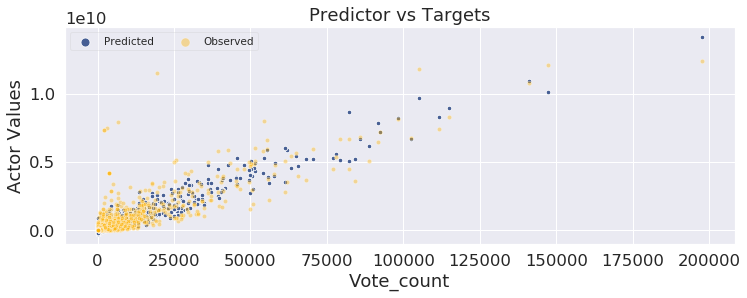

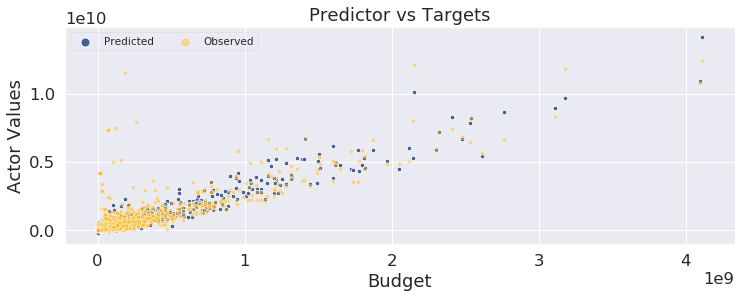

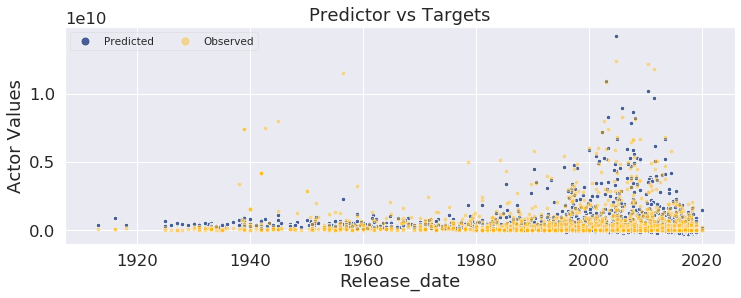

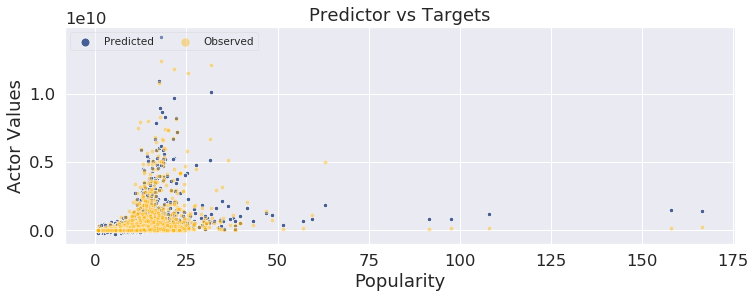

In [89]:
# plot predictors vs. target and predictions for best OLS model
plot_predictors(X_train_sig, y_train_sig, ols_model_sig, predictors_lst)

Under these predictors, the prediction and target values align well.

Now, I will run the holdout data on the best OLS regressor.

I'll recall the training results for comparison.

In [90]:
# get training statistics for model with only significant predictors
get_cv_results(X_train_sig, y_train_sig)

'Average Score: 0.86208, Score Range: (0.83079, 0.89243)'

In [91]:
# get houldout statistics for model with only significant predictors
get_cv_results(X_test_sig, y_test_sig)

'Average Score: 0.82983, Score Range: (0.68658, 0.94606)'

The model is overfitting.<br>
Still, the validation score is fairly high for a first attempt, while using a simple regression model.

Now, I'll plot the original data used to train the model with the results on the holdout data.

In [92]:
# get DataFrame for training scores for best OLS model
cv_train_df = get_cv_df(X_train_sig, y_train_sig)
cv_train_df.columns = cv_train_df.columns + '_original'

Mean Score: 0.86208


In [93]:
# get DataFrame for test scores for best OLS model
cv_test_df = get_cv_df(X_test_sig, y_test_sig)
cv_test_df.columns = cv_test_df.columns + '_holdout'

Mean Score: 0.82983


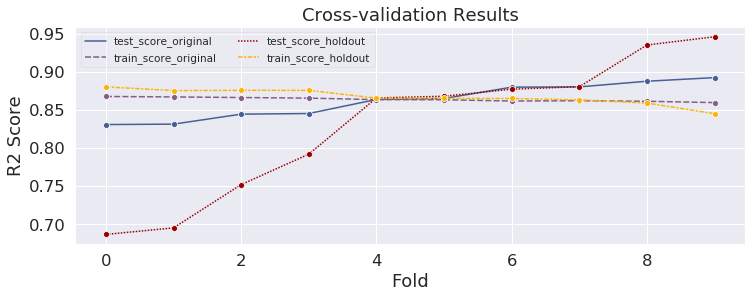

In [94]:
# compare CV results
compare_results(cv_train_df, cv_test_df)

The range of test scores on the holdout set is very broad.<br>
This is understandable, given that the number of samples in that set is one-fifth of the amount in the original test data.